# Problem 4.3

Attribution: Elena 

In [9]:
import emcee

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline
%matplotlib inline

# This enables high res graphics inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

First, we read in the dataset as a Pandas `DataFrame`.

In [10]:
df = pd.read_csv('data/invitro_droplet_data.csv', comment='#') 

Next, we define functions for the theoretical spindle length (our "Model 2") and our log posterior. Our likelihood is given by:
\begin{align}
P(D \mid \theta, \gamma, M_b, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(l_i - l(d_i;\theta, \gamma))^2}{2\sigma^2}\right],
\end{align}

where

\begin{align}
l(d; \theta, \gamma) = \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

We assume uniform priors for $\theta$ and $\gamma$ and a Jeffreys prior for $\sigma$. So our posterior is:
\begin{align}
P(\theta, \gamma, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(l_i - l(d_i;\theta, \gamma))^2\right].
\end{align}

In [11]:
def spindle_length(theta, gamma, d):
    """
    Theoretical model for spindle length
    """
    return gamma * d / scipy.special.cbrt(1 + (gamma * d / theta)**3)
    
def log_post(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    """ 
    # Unpack parameters
    theta, gamma, sigma = p    
    
    if (theta <= 0) or (gamma > 1) or (gamma <= 0) or (sigma < 0):
        return -np.inf
        
    # Theoretical spindle length
    ell_theor = spindle_length(theta, gamma, d)
    
    return -(len(d) + 1) * np.log(sigma) - (1 / (2 * sigma**2)) * np.sum((ell - ell_theor)**2) 

We define 1) the additional arguments (our data) that we will need to pass into the log posterior function, 2) our walker specs, and 3) the starting points for each of our walkers. We randomly draw the starting point for $\gamma$ out of a uniform distribution on (0,1]. The only restriction on $\theta$ and $\sigma$ is that they must be positive values, so we will draw their starting points out of an exponential distribution with mean of 1.

In [12]:
args = (df['Droplet Diameter (um)'], df['Spindle Length (um)'])

# Walker specs
n_dim = 3
n_walkers = 50
n_burn = 1000
n_steps = 5000

p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(0.1, n_walkers) # theta
p0[:,1] = np.random.uniform(1e-5, 1, n_walkers) # gamma
p0[:,2] = np.random.exponential(0.1, n_walkers) # sigma

Finally, we instantiate the sampler, burn it in, and sample.

In [13]:
# Instantiate sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)

# Burn it in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Sample
_ = sampler.run_mcmc(pos, n_steps)

As in the tutorial, we will look at the trace of a single walker for each of our three parameters to check whether it fluctuates around the mean, which would be a sign that the sampler has converged.

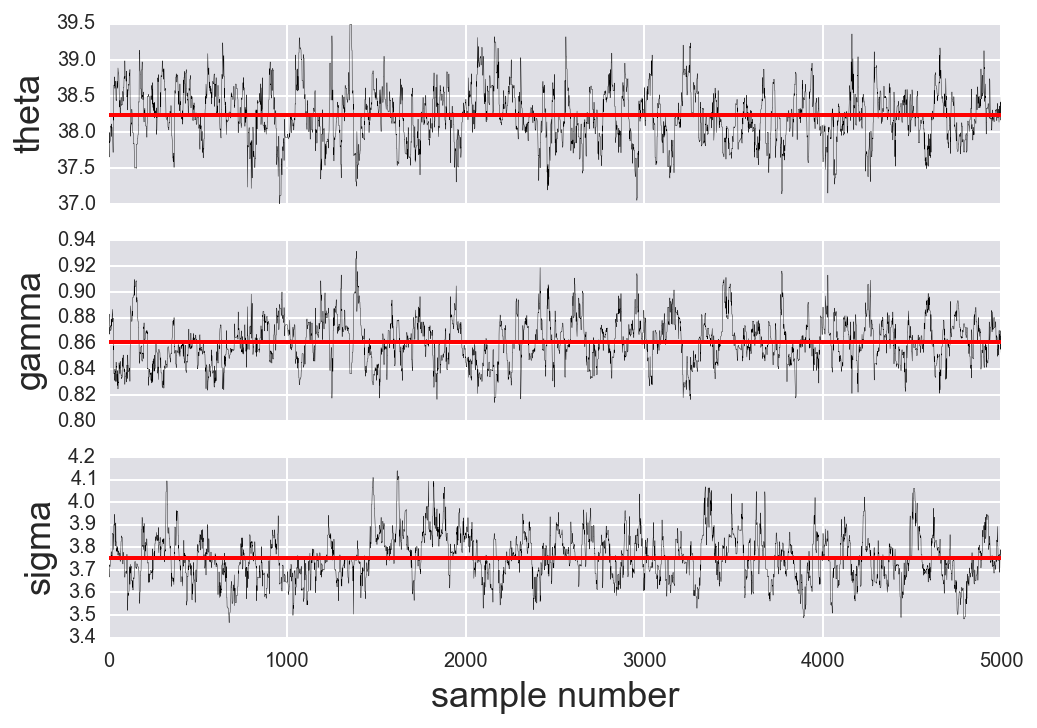

In [20]:
fig, ax = plt.subplots(3, 1, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[2].set_xlabel('sample number')
ax[0].set_ylabel('theta')
ax[1].set_ylabel('gamma')
ax[2].set_ylabel('sigma')

This looks good, so next we will find the MAP for our parameters.

In [21]:
# Get the index of the most probable parameter set
max_ind = np.argmax(sampler.flatlnprobability)

# Pull out values.
theta_MAP, gamma_MAP, sigma_MAP = sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
theta:  {0:.3f}
gamma: {1:.3f}
sigma: {2:.3f}
""".format(theta_MAP, gamma_MAP, sigma_MAP))


Most probable parameter values:
theta:  38.250
gamma: 0.860
sigma: 3.752



The values for $\theta$ and $\gamma$ pretty much match what we previously calculated by optimization, as they should. Let's also calculate error bars for each parameter.

In [24]:
# Compute error bars by taking standard deviation
theta_err, gamma_err, sigma_err = sampler.flatchain.std(axis=0)

print('Error bars:\n', theta_err, gamma_err, sigma_err)

Error bars:
 0.393898985164 0.0174898197984 0.102787446913


Again, these values (for $\theta$ and $\gamma$) are very similar to what we got via optimization. Let's plot our regression curve on top of the data, using the most probable values for $\theta$ and $\gamma$.

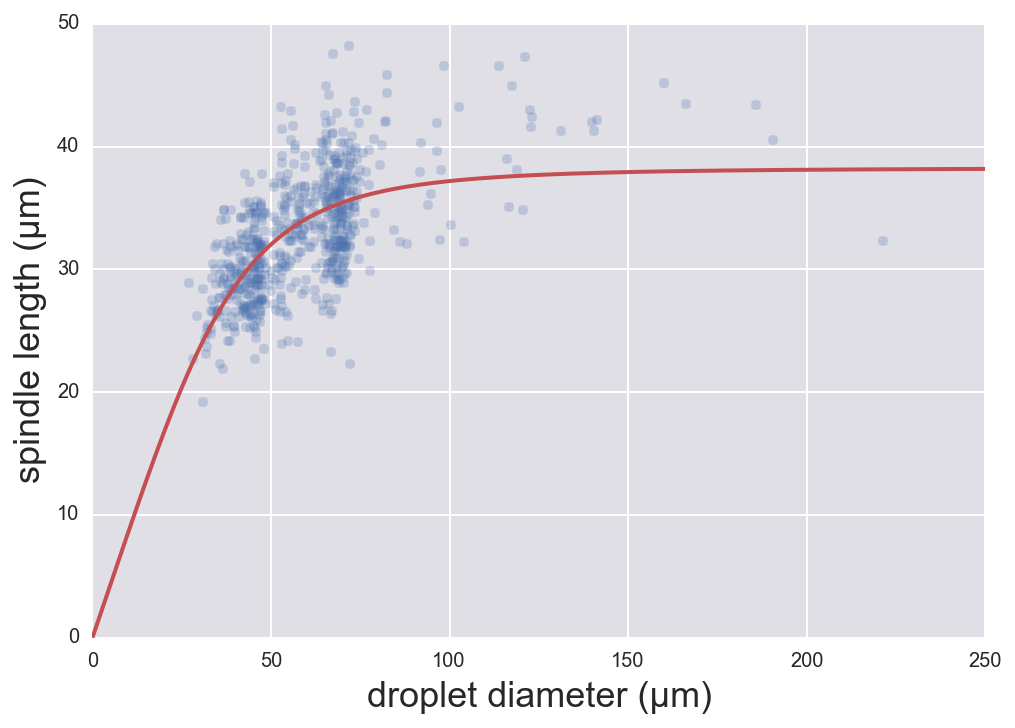

In [27]:
# Values of droplet diameter to plot
d_plot = np.linspace(0, 250, 200)

# Theoretical curve
spindle_theor = spindle_length(theta_MAP, gamma_MAP, d_plot)

# Plot results
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], '.', 
         markersize=10, alpha=0.25)

# Plot the result
plt.plot(d_plot, spindle_theor, '-', color=sns.color_palette()[2])

# Use unicode to do plot label with microns with nicely formatted mu
plt.xlabel(u'droplet diameter (µm)')
plt.ylabel(u'spindle length (µm)')

Now, let's just sample $\sigma$ and look at its distribution.

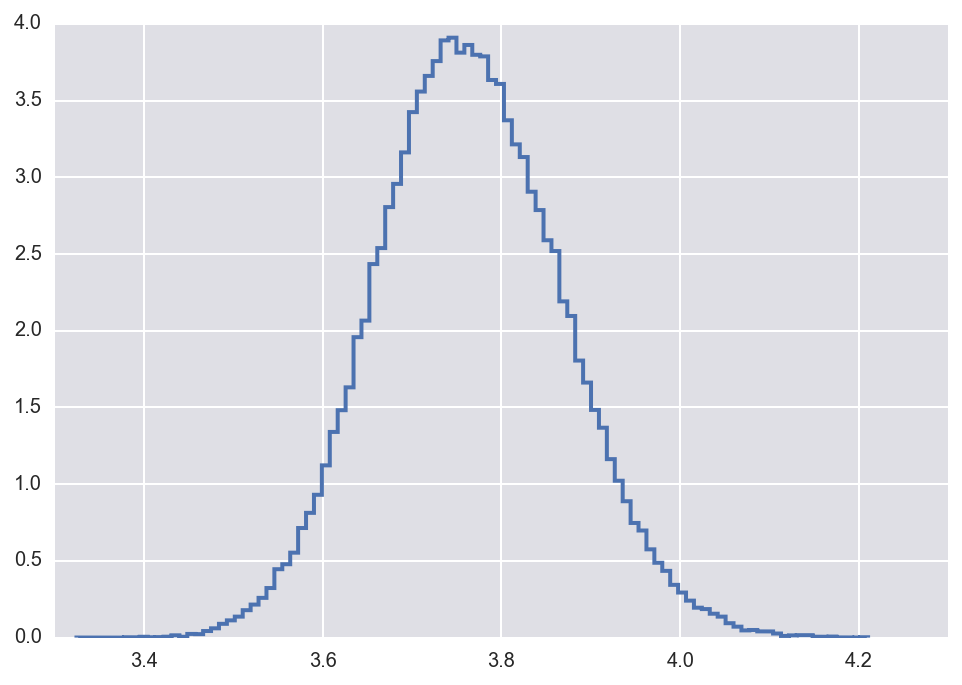

In [23]:
_ = plt.hist(sampler.flatchain[:,2], bins=100, normed=True, 
                   histtype='step', lw=2)

$\sigma$ appears to be Gaussian distributed. This is expected, since in writing the likelihood (and hence the log posterior), we assumed that the data vary from the model in a Gaussian manner -- and the estimators for parameters of a Gaussian distribution will in turn be asymptotically Gaussian distributed.$^1$ The fact that the MAP is around 3.75 means that the best estimate of the standard deviation of the data with respect to the theoretical model is 3.75 µm. That's lower than we might have guessed from just looking at the plot of the regression curve overlaid on top of the data. 

$^1$http://www.statlect.com/normal_distribution_maximum_likelihood.htm

Plotting the MCMC results for $\theta$ and $\gamma$, we also see that these two parameters are negatively correlated, as we saw in tutorial 3a.

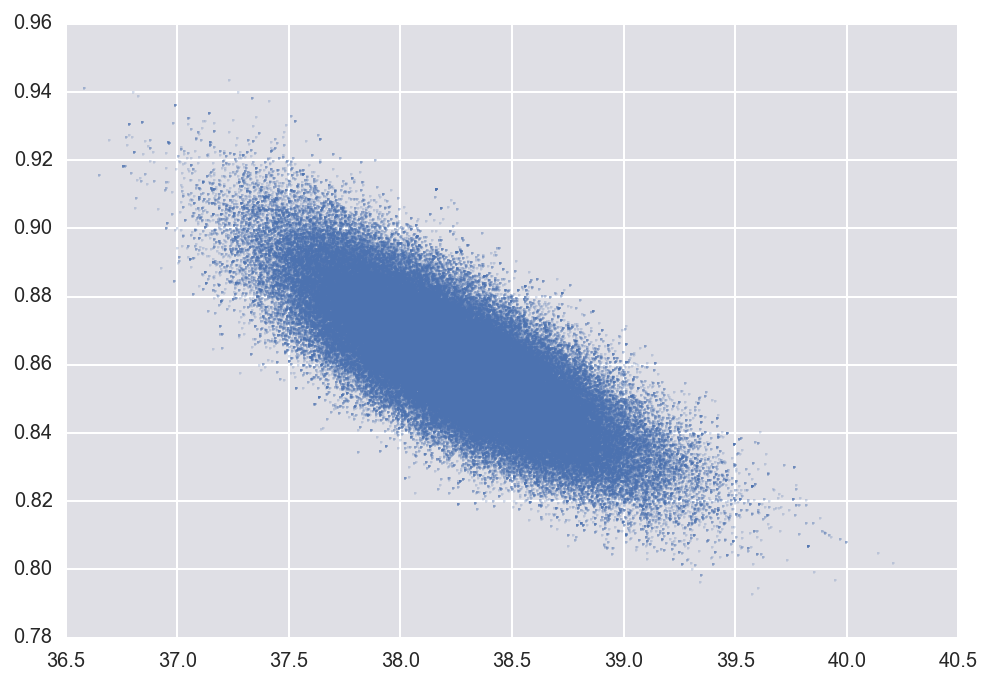

In [31]:
plt.plot(sampler.flatchain[:,0], sampler.flatchain[:,1], '.', markersize=3, alpha = 0.25)